# Project: Stochastic Gradient Hamiltonian Monte Carlo

In this project we are going to implement standard HMC, HMC with MH, Naive SGHMC and SGHMC with Friction.

# standard HMC

### Basic settings

Suppose we want to sample from the posterior distribution: 
$$p(\theta|D) \propto exp(-U(\theta))$$ where $D = \{x_{1\:n}\}$
which are independent and $U$ is the potential energy fucntion: 
$$U = -\sum_{x_i \in D}\log p(x|\theta)- \log p(\theta)$$
We will sample from joint distribution $$\pi(\theta, r) \propto exp(-U(\theta)-\frac{1}{2}r^TM^{-1}r)$$
where r is the auxiliary momentum variables and M is the mass matrix. They define the kinetic energy together.
Then we discard r and keep $\theta$.

The Hamiltonian function is:
$$H(\theta, r)=U(\theta)+\frac{1}{2}r^TM^{-1}r$$
The Hamiltonian dynamics are:
$$d\theta = M^{-1}r dt\\ dr=-\triangledown U(\theta) dt$$

### Implement HMC

We use a univariate $\theta$ for illustration. Suppose $U(\theta)=-2\theta^2+\theta^4$. Based on $U(\theta)$, we need to define functions $\triangledown U, H$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# need to be set manually
def U(theta):
    '''compute U'''
    
    return -2*theta**2 + theta**4

In [3]:
# need to be set manually
def grad_U(theta):
    '''compute gradient of U'''
    
    return -4*theta+4*theta**3

In [4]:
# need to be set manually
def set_M(theta):
    '''initialize M as identity with resonable dimensions based on theta, which is a np.array'''
    
    return np.eye(theta.shape[-1])

In [5]:
# need to be set manually
def H(theta, r, M):
    '''compute Hamiltonian function'''
    assert M.shape[0]==M.shape[1], 'M is not a square matrix'
    
    return U(theta) + 1/2* r.T @ np.linalg.inv(M) @ r

In [6]:
def std_HMC(theta0, epsilon, nmc, max_iteration):
    '''
    implement standard HMC
    theta0: np.array
    epsilon: float
    '''
    
    theta_post = [theta0]
    M = set_M(theta0)
    m = M.shape[0] # number of parameters
    
    i = 1
    while i < (nmc+1):
        r = ri = np.random.multivariate_normal(np.zeros(m), M).reshape(-1,1)
        
        theta= theta0
        
        #simulate discretization of Hamiltonian Dynamics
        r = r - epsilon * grad_U(theta)/2
        
        for j in range(max_iteration):
            theta = theta + epsilon * np.linalg.inv(M) @ r
            r = r - epsilon * grad_U(theta)
        
        # MH correction
        u = np.random.rand()
        ro = np.exp(H(theta, r, M) - H(theta_post[i-1], ri, M))
        if u < min(1,ro):
            theta_post.append(theta[0,0])
            i += 1
            
    return theta_post[1:]

In [7]:
x = std_HMC(np.array([1]), 0.01, 1000, 100)

# Stochastic Gradient HMC with Naive Approach

The Naive approach refers to the simple plug-in estimator of $\triangledown \tilde{U}(\theta) = -\frac{|D|}{|\tilde{D}|}\sum_{x \in \tilde{D}} \triangledown log p(x|\theta) - \triangledown log p(\theta)$ with minibatch $\tilde{D}$. $\triangledown \tilde{U}(\theta)$ is computationally easier, but then the resulting joint distribution $\pi(\theta, r)$ is not invariant.

The Hamiltonian Dynamics are:
$$d\theta = M^{-1}r dt\\ dr=-\triangledown U(\theta) dt + N(0,2B(\theta)) dt$$
where $B(\theta) = \frac{1}{2}\epsilon V(\theta)$

# need to find covariance of the stochastic gradient noise

Since $\epsilon$ is small, it does not really matter that V is. Thus we take V as identity.

### Implement Naive SGHMC

# SGHMC with Friction

Add friction term to momentum update:
$$
d\theta = M^{-1}r dt\\
dr = - \triangledown U(\theta)dt - BM^{-1}rdt+N(0,2Bdt)
$$

# new proposal for SGHMC with friction

In [8]:
import scipy.stats as sta

In [9]:
# set up target distribution; normal in this example
def p_x_theta(theta, x):
    '''
    density of target distribution
    theta = [mean,std]
    '''
    
    N = sta.norm(theta[0], theta[1])
    
    return N.pdf(x)

In [10]:
# set up prior for theta
def grad_prior_theta(theta):
    '''prior'''
    
    sta.invgamma
    ...
    

In [11]:
def grad_log_p_x_theta(D_, theta):
    
    ...
    return logp

In [12]:
# set up gradient of U with respect to batch D_
def grad_U(theta, D_, n):
    '''
    gradient of U(theta)
    n is the total number of sample
    D_ is a minibatch
    '''
    
    return -n/D_.shape[0]*grad_log_p_x_theta(D_, theta)-grad_prior_theta(theta)


In [13]:
# minibatch function with m batchs
def minib(x, m):
    '''
    create m minibatchs of x
    x: data
    m: number of minibatchs
    '''
    
    np.random.shuffle(x)
        
    return np.array_split(x, m)

In [14]:
def theta_update(theta, r, M, epsilon):
    '''update theta in HMC'''
    
    return theta + epsilon * np.linalg.inv(M) * r

In [15]:
def r_update(theta ,r ,M ,gU, epsilon):
    '''update r'''
    m = theta.shape[0]
    C = np.eyes(m) # take C as identiy 
    B = 1/2*epsilon*C # take B as from identiy V, since small epsilon will discount any effects
    
    return r - epsilon * gU - epsilon * C @ np.linalg.inv(M) * r + np.random.multivariate_normal(np.zeros(M.shape[0]), 2*epsilon*(C-B)).reshape(-1,1)

In [16]:
def SGHMC_friction(X, theta0, m, M, epsilon = 1e-6, nvm=10000):
    '''SGHMC with friction'''
    
    M = set_M(theta0)
    m = M.shape[0] # number of parameters
    theta_post = []
    V = np.eyes(m) # covariance matrix of parameters
    n = X.shape[0]
    
    for i in range(nvm):
        r = np.random.multivariate_normal(np.zeros(m), M).reshape(-1,1)
        theta = theta0
        
        # create minibatch
        b = minib(X,m)
        for i in range(m):
            gU = grad_U(theta, b[i], n) 
            
            theta = theta_update(theta, r, M, epsilon)
            r = r_update(theta ,r ,M ,gU, epsilon)
            
        theta_post.append(theta)
    
    
    return theta_post

In [123]:
def SGHMC_friction2(theta0, X, grad_logden_data, grad_logden_prior, eps, i, B, C, batch_size, M = None):
    '''
    SGHMC with friction:
    theta0(numpy array): starting position of theta
    X: data
    grad_logden_data: gradient of the data log density
    grad_logden_prior: gradient of the prior log density
    eps: step size
    i: number of iterations
    B: noise estimate
    C: user specified friction term
    batch_size: size of minibatches
    M: Mass matrix
    '''
    
    def minib(x, batch_size):
        '''
        create minibatchs of x
        x: data
        batch_size: size of minibatch, if len(x)/batch_size is not integer, some batches wille have smaller sizes
        '''
        m = np.ceil(x.shape[0]/batch_size)
        np.random.shuffle(x)

        return np.array_split(x, m)
    
    n = theta0.shape[0]
    rt = np.zeros(i+1)
    thetat = np.zeros(i+1)
    thetat[0] = theta0
    batch = minib(X,batch_size)
    m = len(batch)
    
    if(M is None):
        M = np.eye(n)
    
    for t in range(i):
        rt[t] = np.random.multivariate_normal(np.zeros(n), M).reshape(-1,1)
        theta0,r0 = thetat[t],rt[t]
        thetai,ri = np.array([theta0]),np.array([r0])
        for j in range(m):
            thetai = thetai + eps * np.linalg.inv(M) @ ri
            sumg = 0
            for x in batch[j]:
                sumg += grad_logden_data(x,thetai)-grad_logden_prior(thetai)
            gU = - X.shape[0]/batch[j].shape[0]* sumg
            ri = ri - eps * gU - eps * C @ np.linalg.inv(M) @ ri + np.random.multivariate_normal(np.zeros(n), np.array(2*eps*(C-B)).reshape(-1,n)).reshape(-1,1)
        thetat[t+1],rt[t+1] = thetai, ri
    
    return thetat,rt
        

In [132]:
def grad_logden_data(x,theta):
    return -(-4*theta+4*theta**3)/50

In [133]:
def grad_prior(theta):
    return 0

In [134]:
theta,r = SGHMC_friction2(theta0 = np.array([0]),X = np.zeros(50),grad_logden_data = grad_logden_data,grad_logden_prior = grad_prior,
                eps=0.1,i=1000, B=np.array([0]),C=np.array([2]),batch_size = 10)

In [138]:
import seaborn as sns

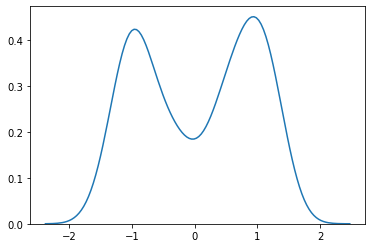

In [139]:
sns.kdeplot(theta)

## take simulated data from normal distribution as example

Simulate 1000 samples from N($\mu=10$,100). We want to sample $\mu$ from the posterior $p(\mu|D)$.

In [17]:
x = np.random.normal(10,10,1000)
x

array([ 17.80940264, -12.90820253,   7.28730158,  11.06798918,
        11.60151888,  11.52779961,  13.94589599,   6.89335457,
         3.16399043,   8.40223896,  13.50102312,  -1.40375701,
        19.15975341,   4.18365302,  17.96333108,  24.49682133,
        22.0669001 ,  28.21241096,  13.91144207,  12.41888075,
        27.3721917 ,  12.00762573,  22.81031273,  -1.66883626,
        14.16268348,  10.31081083,   3.37091621,   1.85686351,
         9.12526968,   1.23114633,   8.73409384,  12.12821401,
        21.82392889,  -1.67923164,   7.77180986,  28.60366585,
         3.398824  ,  11.904201  ,  12.57085559,  -1.29833357,
         0.76868049,   6.0881222 ,  20.58094711,  13.86919508,
        18.89686745,   8.20342771,  11.93477613,  27.14852621,
         2.67665932,  17.02110929,  21.18588254,   3.9019094 ,
        19.22471588,  19.99143714,   8.89151477,  10.780995  ,
        23.25832844,  19.99770292,  24.17510603,  -1.59341681,
        -2.83259822,  14.63235251, -12.78731209,  16.17

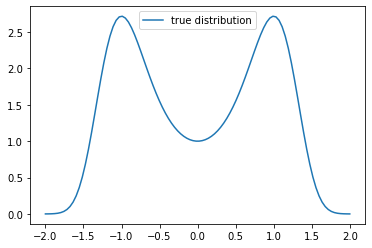

In [30]:
theta = np.linspace(-2,2,100)
p = np.exp(2*theta**2-theta**4)
fig, ax = plt.subplots()
ax.plot(theta,p,label = "true distribution")
ax.legend(loc= "upper center")

array([[1., 0.],
       [0., 1.]])